### Single Vehicle Motion Validation
- PC Crash simulations vs. Pycrash
- Steering / Braking maneuvers

##### Notebook option - enable reloading modules

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
#sys.path.insert(0,'< your path >')
sys.path.insert(0, '/Users/joe/Documents/pycrash')

In [5]:
os.chdir('..')

In [6]:
os.getcwd()

'/Users/joe/Documents/pycrash/projects/validation - single vehicle motion'

In [7]:
import pycrash
from pycrash.project import Project, project_info, load_project
from pycrash.vehicle import Vehicle
from pycrash.kinematics import SingleMotion
from pycrash.visualization.kinematics_compare import compare_kinematics
from pycrash.visualization.tire_details import tire_details, vertical_forces, long_forces
from pycrash.visualization.cg_motion_compare import cg_motion
from pycrash.visualization.model_interval import plot_motion_interval

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate
import os
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Current values for defined constants:
maximum available friction (mu_max) = 0.8
time step for vehicle motion (dt) = 0.01 s


### Generate dataframe of validation data
- use validation steer / brake / throttle inputs
- inputs are same dt as pycrash will have to check in future

List of column names used when loading PC Crash data  
PC Crash rotation is positive ccw so, tire locations are swapped here  

In [8]:
pc_crash_column_names = ['t', 'ax', 'ay', 'az', 'phi_deg', 'rf_fy', 'lf_fy',
                         'rr_fy', 'lr_fy', 'delta_deg', 'rf_delta_deg', 'steer',
                         'steer_rate', 'X', 'Y', 'Z', 'roll', 'pitch', 'theta_deg',
                         'Vx', 'Vy', 'Vz', 'rf_fz', 'lf_fz', 'rr_fz', 'lr_fz',
                         'rf_alpha', 'lf_alpha', 'lr_alpha', 'rr_alpha']

#### Load PC Crash Data
- List of validation data files:

In [9]:
test_file_list = os.listdir(os.path.join(os.getcwd(), 'data', 'external'))
print('List of tests for analysis:')
test_file_list

List of tests for analysis:


['40-mph-fishhook-nhtsa-data.xlsx',
 '30-mph-steer-data.xlsx',
 '30-mph-braking-full-data.xlsx',
 '45-mph-fishhook-nhtsa-data.xlsx',
 '35-mph-fishhook-nhtsa-data.xlsx',
 '15-mph-steer-data.xlsx',
 '30-mph-braking-partial-data.xlsx']

In [10]:
test_do = 1 # <- cho|ose test number from list to process
print(f'Test to be processed: {test_file_list[test_do]}')

Test to be processed: 30-mph-steer-data.xlsx


In [11]:
df = pd.read_excel(os.path.join(os.getcwd(), 'data', 'external', test_file_list[test_do]),
                            na_filter = False, header = None, names = pc_crash_column_names, skiprows = 2,
                            usecols = 'A:AD')

Convert units

In [24]:
df.steer = [x * -1 for x in df.steer]  # reverse steer - PC-Crash is positive ccw

# convert velocities to fps
df.Vx = [x * 1.46667 for x in df.Vx]
df.Vy = [x * 1.46667 for x in df.Vy]
df.Vz = [x * 1.46667 for x in df.Vz]

# convert acceleration to fps/s
df.ax = [x * 32.2 for x in df.ax]
df.ay = [x * 32.2 for x in df.ay]
df.az = [x * 32.2 for x in df.az]

# convert tire forces to lb
df.lf_fy = [x * 1000 for x in df.lf_fy]
df.rf_fy = [x * 1000 for x in df.rf_fy]
df.lr_fy = [x * 1000 for x in df.lr_fy]
df.rr_fy = [x * 1000 for x in df.rr_fy]

# steer angle in radians
df['delta_rad'] = [x / 180 * math.pi for x in df.delta_deg]

# integrate velocities to get displacements
df['Dx'] = 0 + integrate.cumtrapz(list(df.Vx), list(df.t), initial=0)
df['Dy'] = 0 + integrate.cumtrapz(list(df.Vy), list(df.t), initial=0)
df.head()

,t,ax,ay,az,phi_deg,rf_fy,lf_fy,rr_fy,lr_fy,delta_deg,rf_delta_deg,steer,steer_rate,X,Y,Z,roll,pitch,theta_deg,Vx,Vy,Vz,rf_fz,lf_fz,rr_fz,lr_fz,rf_alpha,lf_alpha,lr_alpha,rr_alpha,delta_rad,Dx,Dy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0,0.0,0.0,1.79,0.0,0.0,0.0,64.533627,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0,4.4,0.0,1.79,0.0,0.0,0.0,64.533627,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,6.453363,0.0
2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0,8.8,0.0,1.79,0.0,0.0,0.0,64.533627,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,12.906725,0.0
3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0,13.2,0.0,1.79,0.0,0.0,0.0,64.533627,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,19.360088,0.0
4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0,17.6,0.0,1.79,0.0,0.0,0.0,64.533627,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,25.813451,0.0


### Create Vehicle Input
`vehicle_input_dict` is a Python dictionary containing necessary vehicle inputs

In [25]:
malibu = Vehicle('veh1')

In [26]:
# PC Crash vehicle specifications
vehicle_input_dict = {"year":2004,  # <- creates dictionary of vehicle data for input
"make":"Chevrolet",
"model":"Malibu",
"weight":3298,
"vin":"1G1ZU54854F135916",
"brake":0,
"steer_ratio":15.9,
"init_x_pos":0,
"init_y_pos":0,
"head_angle":0,
"width":70 / 12,
"length":187 / 12,
"hcg":21.5 / 12,
"lcgf":38.1 / 12,
"lcgr":67.9 / 12,
"wb":106 / 12,
"track":60 / 12,
"f_hang":38 / 12,
"r_hang":43 / 12,
"tire_d":26.2 / 12,
"tire_w":8.5 / 12,
"izz":2040,
"fwd":1,
"rwd":0,
"awd":0,
"A":100,
"B":41,
"k":1000,
"L":0,
"c":0,
"vx_initial":0,
"vy_initial":0,
"omega_z":0}

#### basic plot using Pandas - steer angle versus time

<AxesSubplot:xlabel='t'>

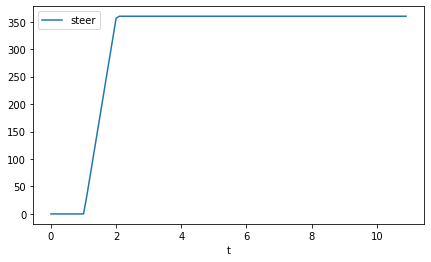

In [27]:
df.plot(x='t', y='steer', figsize=(7,4))

create driver input dataframe from PC Crash input data

In [33]:
end_time = df.t.max()
t = np.arange(0, end_time + 0.1, 0.1).tolist()
throttle = [0] * len(t)                      
brake = [0] * len(t)              
steer = list(df.steer)
driver_input_dict = {'t':t, 'throttle':throttle, 'brake':brake, 'steer':steer}
driver_input_df = pd.DataFrame.from_dict(driver_input_dict)

#### Assign validation data to `veh2`

In [34]:
veh2 = Vehicle('Veh2', vehicle_input_dict)
veh2.driver_input = driver_input_df
# apply validation data as a model result
veh2.model = df

Vehicle inputs for Veh2 applied successfully


#### vehicle:
- "Vehicle" stores information about a single vehicle - all possible inputs do not need to be entered
- creating a Vehicle requires a "name" which is used to identify the vehicle in outputs / plots etc.


#### Create Pycrash vehicle
- set initial velocity
- try varying cg height - `hcg`
- you will get a `UserWarning` but it's fine

In [35]:
veh1 = Vehicle('Veh1', vehicle_input_dict)
veh1.time_inputs(t, throttle, brake, steer)
veh1.vx_initial = 30
veh1.hcg = 21.5 / 12  # <- set CG height

Vehicle inputs for Veh1 applied successfully
Driver inputs applied to Veh1


### Create Single Motion Instance
- simulation is run when instance is created which takes a few seconds
- model is generating data at each time step as well as all position data to draw vehicle position

In [36]:
sim_defaults = {'dt_motion': 0.005,
                'mu_max': 0.76,
                'alpha_max': 0.174533}

In [37]:
simulation_name = '30 mph steer'
print(f'Creating Simulation: {simulation_name}')
run = SingleMotion(simulation_name, veh1)

Creating Simulation: 30 mph steer
Maximum allowable friction: 0.76
Time step for vehicle motion (s) : 0.01
Maximum tire slip angle (deg): 10.00
Driver input for Veh1 of shape = (1091, 4)
Vehicle motion will be simulated for 10.9 seconds


In [38]:
plot_motion_interval(run.veh, num_itter = 12)

In [ ]:
cg_motion(run.veh.model, df, 'Pycrash', 'PC-Crash')

In [ ]:
#run.veh.model.to_csv('45_mphFishook_1footcg.csv', index=False)

### Plot Kinematic Data

In [ ]:
run.plot_model()

Last five rows

In [ ]:
run.veh.model.tail()

### Plot Vehicle Motion

In [ ]:
i = len(run.veh.model) - 1 # draw motion at end of simulation
print(f"Time: {run.veh.model.t[i]}")
run.global_motion(i)

### Compare to PC Crash Model

In [ ]:
# calculate vehicle slip angle for pycrash model - need to correct
phi_rad = []
phi_deg = []
for i in range(len(run.veh.model.t)):
    phi_rad.append(math.atan2(run.veh.model.vy[i], run.veh.model.vx[i])) 
    phi_deg.append(math.atan2(run.veh.model.vy[i], run.veh.model.vx[i])*(180 / math.pi))
    
run.veh.model['phi_rad'] = phi_rad
run.veh.model['phi_deg'] = phi_deg

In [ ]:
compare_kinematics(run.veh.model, df, 'Pycrash', 'PC-Crash')

### Get max / min values from output
output is accessed - 

In [ ]:
# pycrash
run.veh.model.head()

In [ ]:
# forward acceleration greatest difference at peaks
print(f'Minimum forward acceleration Pycrash: {run.veh.model.au.min() / 32.2:0.2f} g')
print(f'Minimum forward acceleration PC-Crash: {df.ax.min() / 32.2:0.2f} g')
print(f'Difference: {(run.veh.model.au.min() - df.ax.min()) / 32.2:0.4f} g')
# rightward acceleration greatest difference at end
print(f'Rightward acceleration at end of sim Pycrash: {run.veh.model.av[len(run.veh.model)-1] / 32.2:0.2f} g')
print(f'Rightward acceleration at end of sim  PC-Crash: {df.ay[len(df)-1] / 32.2:0.2f} g')
print(f'Percent Difference: {(run.veh.model.av[len(run.veh.model)-1] - df.ay[len(df)-1]) / 32.2 :0.4f} g')

### Get position data for validation vehicle

### Tire Details
- Pycrash model only

In [ ]:
tire_details(run.veh)

In [ ]:
vertical_forces(run.veh)

#### Compare heading angles

In [ ]:
run.veh.model.plot(x='t', y='beta_deg', figsize=(7,4), title="Pycrash Heading Angle")

In [ ]:
print(f"Pycrash vehicle heading angle of: {run.veh.model.beta_deg[650]:0.1f} deg at {run.veh.model.t[650]} s")
print(f"PC-Crash vehicle heading angle of: {df.theta_deg[65]:0.1f} deg at {df.t[65]} s")
print(f"Difference: {run.veh.model.beta_deg[650]-df.theta_deg[65]:0.1f}")

### Compare Vehicle Positions

In [ ]:
disp_pycrash = run.veh.model[['t', 'Dx', 'Dy']].copy()
disp_pycrash.rename(columns={'Dx':'Dx_pycrash', 'Dy':'Dy_pycrash'}, inplace=True)
disp_pccrash = df[['t', 'Dx', 'Dy']].copy()
disp_pccrash.rename(columns={'Dx':'Dx_pccrash', 'Dy':'Dy_pccrash'}, inplace=True)
disp_compare = pd.merge(disp_pccrash, disp_pycrash, how = 'left', on = 't')
disp_compare.head()

In [ ]:
dx_pycrash = disp_compare.Dx_pycrash.to_list()
dy_pycrash = disp_compare.Dy_pycrash.to_list()
dx_pccrash = disp_compare.Dx_pccrash.to_list()
dy_pccrash = disp_compare.Dy_pccrash.to_list()
time = disp_compare.t.to_list()
dx_diff = [(x - y)**2 for (x,y) in zip(dx_pycrash, dx_pccrash)]
dy_diff = [(x - y)**2 for (x,y) in zip(dy_pycrash, dy_pccrash)]
c_sqrd = [np.sqrt(x + y) for (x,y) in zip(dx_diff, dy_diff)]

In [ ]:
c_sqrd[65]

In [ ]:
c_sqrd_21in = c_sqrd.copy()

In [ ]:
c_sqrd_1ft = c_sqrd.copy()

In [ ]:
max(c_sqrd)

In [ ]:
c_sqrd_21in[65]

In [ ]:
c_sqrd_1ft[65]

In [ ]:
print(f"Maximum resultant distance between the CG: {max(c_sqrd):0.2} feet")

In [ ]:
plt.figure(figsize=(9,6))
#plt.plot(time, c_sqrd_2, c='black', linewidth=2.0)
plt.plot(time, c_sqrd_1ft, c='black', linewidth=2.0)
plt.plot(time, c_sqrd_21in, c='green', linewidth=2.0)
plt.xlabel("Simulation Time (s)", fontsize=16)
plt.ylabel("Resultant Difference (feet)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
x_diff_plot = [dx_pycrash[-1], dx_pccrash[-1]]
y_diff_plot = [dy_pycrash[-1], dy_pccrash[-1]]

In [ ]:
colors = ['green', 'black']
plt.scatter(x_diff_plot, y_diff_plot, c=colors)
plt.show()

### Save model output for plotting in r markdown

In [37]:
run.veh.model.to_pickle(os.path.join(os.getcwd(), 'reports', 'single_motion_model_run1.pkl'))

### Save driver inputs

In [40]:
veh1.driver_input.to_pickle(os.path.join(os.getcwd(), 'reports', 'driver_input.pkl'))

In [41]:
os.getcwd()

'/Users/joe/Documents/pycrash/projects/validation - single vehicle motion'

### Save Project to file that was created when project was generated
`Note:` it's generally unecessary to save the project as long as the original script remains intact

### Load Project Datafile that was created when project was instantiated
- the project object contains information needed to run other parts of Pycrash
- not necessary to load project data to run simulations - used to save data

#### Get project information - used to import project object

In [30]:
project_info('validation - single vehicle motion')

This saved project contains:
Object of type "project" with name "validation - single vehicle motion"
Object of type "vehicle" with name "Veh1"
Object of type "vehicle" with name "Veh2"
Object of type "singlemotion" with name "30 mph steer"
list objects in this order for loading project: ['validation - single vehicle motion', 'Veh1', 'Veh2', '30 mph steer']
Example: project_name, veh1, veh2 = load_project('project_name')


In [32]:
proj, veh1, veh2, run = load_project('validation - single vehicle motion')
proj.show()

Attributes in project: 4
----------------------------------  ------------------------  -----------  ---------------  --------------------
Project                             Description               Impact Type  Simulation Type  Note
validation - single vehicle motion  planar motion simulation               SV               pc crash comparisons
----------------------------------  ------------------------  -----------  ---------------  --------------------


### look at attributes assigned to project class

In [33]:
proj.__dict__

{'name': 'validation - single vehicle motion',
 'project_path': '/Users/joe/Documents/pycrash/projects/',
 'pdesc': 'planar motion simulation',
 'sim_type': 'SV',
 'impact_type': None,
 'note': 'pc crash comparisons',
 'type': 'project'}

may need to correct project_path should be the main projects folder, one up from the current project directory

In [18]:
proj.project_path = '< new path if necessary >'

### Save data generated above

In [34]:
proj.save_project(veh1, veh2, run)

### Reload and check

In [35]:
project_info('validation - single vehicle motion')

This saved project contains:
Object of type "project" with name "validation - single vehicle motion"
Object of type "vehicle" with name "Veh1"
Object of type "vehicle" with name "Veh2"
Object of type "singlemotion" with name "30 mph steer"
list objects in this order for loading project: ['validation - single vehicle motion', 'Veh1', 'Veh2', '30 mph steer']
Example: project_name, veh1, veh2 = load_project('project_name')


In [49]:
proj, veh1, veh2, run = load_project('validation - single vehicle motion')
proj.show()

Attributes in project: 4
{'validation - single vehicle motion': <pycrash.project.Project object at 0x137484490>, 'veh1': <pycrash.vehicle.Vehicle object at 0x137484460>, 'veh2': <pycrash.vehicle.Vehicle object at 0x137484220>, 'singlemotion1': <pycrash.kinematics.SingleMotion object at 0x137484d00>}
----------------------------------  ------------------------  -----------  ---------------  --------------------
Project                             Description               Impact Type  Simulation Type  Note
validation - single vehicle motion  planar motion simulation               SV               pc crash comparisons
----------------------------------  ------------------------  -----------  ---------------  --------------------


In [52]:
veh1.show()

name -> Veh1
type -> vehicle
year -> 2004.0
make -> Chevrolet
model -> Malibu
weight -> 3298.0
vin -> 1G1ZU54854F135916
brake -> 0.0
steer_ratio -> 15.9
init_x_pos -> 0.0
init_y_pos -> 0.0
head_angle -> 0.0
width -> 5.833333333333333
length -> 15.583333333333334
hcg -> 1.7916666666666667
lcgf -> 3.1750000000000003
lcgr -> 5.658333333333334
wb -> 8.833333333333334
track -> 5.0
f_hang -> 3.1666666666666665
r_hang -> 3.5833333333333335
tire_d -> 2.183333333333333
tire_w -> 0.7083333333333334
izz -> 2040.0
fwd -> 1.0
rwd -> 0.0
awd -> 0.0
A -> 100.0
B -> 41.0
k -> 1000.0
L -> 0.0
c -> 0.0
vx_initial -> 45
vy_initial -> 0.0
omega_z -> 0.0

First five rows of driver_input:
   throttle  brake  steer     t
0       0.0    0.0    0.0  0.00
1       0.0    0.0    0.0  0.01
2       0.0    0.0    0.0  0.02
3       0.0    0.0    0.0  0.03
4       0.0    0.0    0.0  0.04
